In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms
from torchvision import models


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools

import PIL

import dataset_class_image
import torch_net_class

import functools
import operator

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
"""
function for training loop
"""

def step(model, input_data, batch_size, loss_func, optimizer, epoch, batch_nr, device, log_file, mode="val"):
        if mode == "train":
            model.train()
        elif mode == "val":
            model.eval()
        
        #input data splitted into features and labels
        feat_batch = input_data[0].to(device)
        label_batch = input_data[1].to(device)
        
        #input_size = model.get_input_size()
        #output_size = model.get_output_size()
    
        """ALWAYS SET GRADIENT TO ZERO  FOR STANDARD NN (NOT RNNs)"""
        model.zero_grad()
        optimizer.zero_grad()
        
        #print("Label shape {}".format(label_batch.size()))
        
        """
        the peculiar shape (-1, sample_size) is needed, because an entire mini batch is passed on to the network
        initially it is not clear how large such a mini batch is
        the -1 acts as a placeholder in order to keep the number of processed items in one mini batch flexible
        """
        #print("Input {}, batch: {} : {}".format(epoch, batch_nr, feat_batch))
        #log_file.write("Input {}, batch: {} : {}\n".format(epoch, batch_nr, feat_batch))
        #plt.imshow( input_data[0].view((28,28)) )
        
        model_input_shape = tuple([-1] + list(input_size))
        #print("Reshaping to {}".format( feat_batch.view(model_input_shape).double().size() ))
        output = model(feat_batch.view(model_input_shape).float())
        output = output.to(device)
    
        #print("Output {}, batch: {} : {}".format(epoch, batch_nr, output))
        #print("Label {}, batch: {} : {}".format(epoch, batch_nr, label_batch))
        #log_file.write("Output {}, batch: {} : {}\n".format(epoch, batch_nr, output))
        
        #print("Input shape {}".format(feat_batch.size()))
        #print("Label shape {}".format(label_batch.size()))
        #print("Output shape {}".format(output.size()))
    
        #print("Feeding forward epoch: {}, batch: {}".format(epoch, batch_nr))
        #log_file.write("Feeding forward epoch: {}, batch: {}\n".format(epoch, batch_nr))
    
        #print("Calculating " + mode + " loss epoch: {}, batch: {}".format(epoch, batch_nr))
        #log_file.write("Calculating " + mode + " loss epoch: {}, batch: {}\n".format(epoch, batch_nr))
        model_output_shape = tuple([-1,output_size])
        """MSE"""
        #loss = loss_func(output.view(-1, output_size).float(), label_batch.view(-1, output_size).float())
        """Cross Entropy"""
        loss = loss_func(output.view(model_output_shape).float(), label_batch.view(-1).long())
        
        
        if mode == "train":
            #print("epoch: {}, batch: {}, loss: {}".format(epoch, batch_nr, loss.item()))
            #print("Performing backprop ...")
            #log_file.write("epoch: {}, batch: {}, loss: {}\n".format(epoch, batch_nr, loss.item()))
            #log_file.write("Performing backprop ...\n")
            loss.backward()
    
            #print("Adjusting weights ...")
            #log_file.write("Adjusting weights ...\n")
            optimizer.step()
    
        return loss, output

"""
function for calculating neuron activation layer sizes.
needed for torch_net_class (has been copied there)
"""
    
def calc_layer_sizes(input_shape, net_struct):
    layer_sizes = [input_shape]
    
    for i in range(len(net_struct)):
        
        new_layer_size = []
        if net_struct[i]["type"] == nn.Linear:
            #print(net_struct[i]["type"])
            new_layer_size = net_struct[i]["layer_pars"]["out_features"]
            
        elif net_struct[i]["type"] == nn.Conv2d:
            kernel_shape = net_struct[i]["layer_pars"]["kernel_size"]
            stride = net_struct[i]["layer_pars"]["stride"]
            
            new_layer_size = []
            #print("layer " + str(i))
            for d in range(len(kernel_shape)):
                prev_layer_l = int(layer_sizes[-1][d+1])
                kernel_l = int(kernel_shape[d])
                new_layer_size.append( (prev_layer_l - kernel_l)//stride + 1 )
            new_layer_size = [net_struct[i]["layer_pars"]["out_channels"]] + new_layer_size
              
        elif net_struct[i]["type"] == nn.MaxPool2d:
            kernel_shape = net_struct[i]["layer_pars"]["kernel_size"]
            stride = net_struct[i]["layer_pars"]["stride"]
            
            new_layer_size = []
            for d in range(len(kernel_shape)):
                prev_layer_l = int(layer_sizes[-1][d+1])
                kernel_l = int(kernel_shape[d])
                #new_layer_size.append(int( (prev_layer_l - kernel_l) + 1 )//stride)
                new_layer_size.append(int( (prev_layer_l - kernel_l)//stride + 1 ))
            
            #new_layer_size = [(layer_sizes[-1][d+1] - kernel_shape[d])/stride + 1 for d in range(len(kernel_shape))]
            
            prev_channels = layer_sizes[-1][0]
            new_layer_size = [prev_channels] + new_layer_size
        
        elif net_struct[i]["type"] == nn.BatchNorm1d or net_struct[i]["type"] == nn.Dropout or net_struct[i]["type"] == nn.Softmax:
                new_layer_size = layer_sizes[-1]
        
        layer_sizes.append(new_layer_size)
    
    return layer_sizes

In [4]:
image_folder = '../FIDS30_edited'
image_names = os.listdir(image_folder)
image_paths = glob.glob(image_folder + "/*/*.jpg")
#print(image_paths)

../FIDS30_edited/pineapples/1.jpg
pineapples


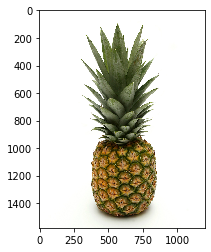

In [5]:
import pathlib
with PIL.Image.open(image_paths[-1]) as test_image:
    print(image_paths[-1])
    print(image_paths[-1].split("/")[-2])
    plt.imshow(test_image)

In [6]:
image_res = 224
custom_transforms = [transforms.RandomResizedCrop(image_res, scale=(0.3,1.0)), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
#custom_transforms = [transforms.RandomResizedCrop(image_res), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]

custom_transforms = transforms.Compose(custom_transforms)
dataset = dataset_class_image.image_dataset(image_folder, image_paths, image_res=image_res, transform=custom_transforms)

In [7]:
print(dataset.labels)
print(len(dataset.labels))

[27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 25 25 25 25 25 25 25 25 25 25

In [8]:
"""load exempalr image"""
test_example = dataset.get_image(0)
print(dataset.label_encoder.classes_[test_example[1]])
print(test_example[0].size())

strawberries
torch.Size([3, 224, 224])


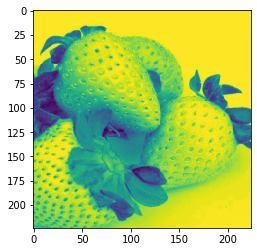

In [9]:
"""display the (augmented) image"""
example_image = test_example[0].detach().cpu().numpy()
plt.imshow(example_image[0])

In [10]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#val_epochs = [2,16,32,48,60]
#val_epochs = [1]
val_epochs = [20,30]
save_state_epochs = [64]


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

fixed_net_struct = []
image_size = dataset.get_image_size()
input_size = image_size
#target_size = 1
output_size = len(dataset.label_encoder.classes_)

#[ [[in_channels, out_channels],[kernel_size], ...]
#kernel_pars = [ [[input_size[0],33],[3,3]], [[33,33],[2,2]], [[33,66],[3,3]], [[66,66],[2,2]], [[66,66],[3,3]] ]
#kernel_pars = [ [[input_size[0],33],[9,9]], [[33,33],[4,4]], [[33,66],[6,6]], [[66,66],[5,5]], [[66,66],[5,5]] ]
#kernel_pars = [ [[input_size[0],24],[11,11]], [[24,24],[3,3]], [[24,48],[5,5]], [[48,48],[3,3]], [[48,96],[3,3]], [[96,96],[2,2]] ]
kernel_pars = [ [[input_size[0],48],[11,11]], [[48,48],[3,3]], [[48,96],[4,4]], [[96,96],[3,3]], [[96,192],[3,3]] ]
act_func = torch.relu

for i, kernel_par in enumerate(kernel_pars):
    if i%2 == 0:
        layer_type = nn.Conv2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": 2,  "bias": True}} )
    else:
        layer_type = nn.MaxPool2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"kernel_size": kernel_par[1], "stride": kernel_par[1][1]}} )
    
    #fixed_net_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "bias": True}} )

conv_sizes = calc_layer_sizes(input_size, fixed_net_struct)
fc_input_size = np.product(conv_sizes[-1])
    
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.BatchNorm1d, "layer_pars": {"num_features": fc_input_size}} )
fixed_net_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.1 }} )
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//2}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//2, "out_features": output_size}, "bias": True, "act_func": act_func} )
fixed_net_struct.append( {"type": nn.Softmax, "layer_pars": {"dim": 0}} )
#dim 0 or 1???

conv_sizes = calc_layer_sizes(input_size, fixed_net_struct)
print(conv_sizes)

#print(fixed_net_struct)

"""If required create list of parameters manually"""

parameter_option = {}
parameter_option["task"] = "classification"
parameter_option["loss_func"] = nn.CrossEntropyLoss
parameter_option["optimizer"] = optim.Adam
parameter_option["batch_size"] = 9 
parameter_option["lr"] = 0.0001
parameter_option["net_struct"] = fixed_net_struct

parameter_option["val"] = "holdout"
parameter_option["split"] = {"train" : 0.8, "val" : 0.2, "test" : 0.0}
#parameter_option["val"] = "k_fold"
#parameter_option["ksplits"] = 5

hyper_parameters = parameter_option

print("size of train set :{}".format(int(parameter_option["split"]["train"]*dataset.get_length())))
print("one batch with size:{}".format(int(parameter_option["split"]["train"]*dataset.get_length())%parameter_option["batch_size"]))
print("size of val set :{}".format(int(parameter_option["split"]["val"]*dataset.get_length())))

[[3, 224, 224], [48, 107, 107], [48, 35, 35], [96, 16, 16], [96, 5, 5], [192, 2, 2], 768, 768, 768, 384, 30, 30]
size of train set :776
size of val set :194


In [11]:
#stop

In [12]:
"""
All errors from each validation epoch will be saved
this list contains them
Saving them in memory is not always viable, which is why they are also saved on the hard drive
"""
#second is fold
#third is epoch
#fourth is prediction or label 
model_errors = []
"""
All errors from each validation epoch will be saved as a file
this list contains the path to these files
"""
#second is fold
#third is epoch
#fourth is prediction or label 
model_errors_path_list = []

"""
The average training loss for each epoch is recorded here
"""
#second is fold
loss_curves = []
loss_path_list = []

"""
States of the neural network are saved as a file
filename is part of this list
"""
#second is fold
#third is epoch
saved_states_file_path_list = []

"""
Set/copy the hyper_parameters
"""
epochs = max(val_epochs)
#input_size = len(pred_attributes)
#target_size = len(target_attributes)
#output_size = len(output_attributes)

lr=hyper_parameters["lr"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"]()

net_struct = hyper_parameters["net_struct"]

"""Choose between holdout validation and k-fold cross validation"""
if hyper_parameters["val"] == "holdout":
    all_indices = list(range(dataset.get_length()))
    indices = [None, None]
    split_ratio = hyper_parameters["split"]
    indices[0], indices[1] = train_test_split(all_indices, test_size=split_ratio["val"], shuffle=True, random_state=random_seed)
    indices = [indices]
elif hyper_parameters["val"] == "k_fold":
    """NOT WORKING ATM"""
    n_splits = hyper_parameters["k_splits"]
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    indices = kf.split(dataset.df)

    #if dataset is split into train test and val, use only train and val for KFold
    #split_indices["train_val"] = split_indices["train"] + split_indices["val"]
    #indices = kf.split(dataset.df.iloc[split_indices["train_val"]])
    
    
"""
Training
"""

fold_model_errors = []
fold_model_errors_path_list = []
fold_saved_states_path_list = []

n_split = 0
"""iterate through all folds (1 for holdout, k for kfold)"""
for fold_indices in indices:

    train_indices = fold_indices[0]
    val_indices = fold_indices[1]

    fold_loss_curve = []
    print("fold {}".format(n_split))
    fold_dir = "fold_{}".format(str(n_split))
    try:
        os.makedirs(fold_dir)
    except FileExistsError:
        pass
    
    """TRANSFER LEARNING TRIAL START"""
    """
    custom_net = models.vgg16(pretrained=True)
    for param in custom_net.parameters():
        param.requires_autograd = False
    n_inputs = 4096
    my_classifier = nn.Sequential(
                      nn.Linear(n_inputs, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.1),
                      nn.Linear(512, output_size),                   
                      nn.Softmax(dim=1))
    
    custom_net.classifier[6] = my_classifier
    
    net = custom_net
    net_parameters = custom_net.classifier[6].parameters()
    """
    """TRANSFER LEARNING TRIAL STOP"""
    
    #initialize network and move to GPU
    
    net = torch_net_class.Net(net_struct, dataset.get_image_size())
    
    net.init_weights(torch.nn.init.xavier_normal_)
    net.set_batch_size(batch_size)
    #net.cuda()
    net.show_layers()
    #train_log_file.write(str(net.get_net_struct()))
    
    net_parameters = net.parameters()
    
    
    net.to(device)
    optimizer = hyper_parameters["optimizer"](net_parameters, lr=lr)

    #create training log
    train_log_file_name = fold_dir +"/train_log.txt"
    train_log_file = open(train_log_file_name, "w")
    #train_log_file.write( "Training log fold {} :\n".format(str(n_split)) )
    
    
    """split training in train and val and load data"""
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    #test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    #val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=val_sampler)
    #test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)


    train_state_dir = fold_dir + "/net_states"
    try:
        os.makedirs(train_state_dir)
    except FileExistsError:
        pass

    train_loss_curve = []
    val_loss_curve = []

    fold_epoch_model_errors = []
    fold_epoch_model_errors_path_list = []
    fold_epoch_saved_states_path_list = []
    for epoch in range(0, epochs):

        batch_nr = 0
        epoch_loss = 0.

        """Actual training step"""
        for train_mini_batch in train_loader:
            batch_nr += 1
            batch_loss, train_output = step(net, train_mini_batch, batch_size, loss_func, optimizer, epoch, batch_nr, device, train_log_file, mode="train")
            epoch_loss += batch_loss.item()

        """Averaging training loss"""
        epoch_loss = epoch_loss/len(train_loader)
        train_loss_curve.append(epoch_loss)
        fold_loss_curve.append(epoch_loss)

        print("mean epoch {} loss: {}".format(epoch, epoch_loss))
        #train_log_file.write("mean epoch loss: {}\n".format(epoch_loss))

        epoch_val_loss = 0

        """save the neural networks state"""
        if (epoch+1) in save_state_epochs or epoch == epochs:
            train_state_epoch_file_name = "state_epoch_{}".format(epoch)
            train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(train_state, train_state_dir + "/" + train_state_epoch_file_name )
            fold_epoch_saved_states_path_list.append(train_state_dir + "/" + train_state_epoch_file_name)
            print("saved model from epoch {}".format(epoch))
            train_log_file.write("saved model from epoch {}\n".format(epoch))

        """
        Valdation
        """
        #validate for each epoch reached in val_epochs
        if (epoch+1) in val_epochs:
        #if (epoch) in val_epochs:

            val_loss = []
            val_pred = []
            val_label = []
            val_i = 0
            for val_mini_batch in val_loader:

                feat_batch = val_mini_batch[0]
                label_batch = val_mini_batch[1]
                val_label.append(label_batch.detach().cpu().numpy())
                val_batch_loss, val_output = step(net, val_mini_batch, batch_size, loss_func, optimizer, epoch, batch_nr, device, train_log_file, mode="val")

                if hyper_parameters["task"] == "classification":
                    """for a classification task"""
                    class_batch_pred = []
                    for val in val_output:
                        class_index = val.argmax().detach().cpu()
                        class_batch_pred.append(class_index)
                    val_pred.append(class_batch_pred)
                elif hyper_parameters["task"] == "regression":
                    """for a regression task"""
                    val_pred.append(val_output.detach().cpu().numpy())


                val_loss.append(val_batch_loss.item())
                #print(val_batch_loss.item())
                val_i += 1

            """SAVE NUMPY ARRAY INSTEAD OF DF"""
            #val_pred_df = pd.DataFrame(np.hstack(val_pred))
            #val_label_df = pd.DataFrame(np.hstack(val_label))
            
            val_pred_df = pd.DataFrame(functools.reduce(operator.iconcat, val_pred, []))
            val_label_df = pd.DataFrame(functools.reduce(operator.iconcat, val_label, []))


            val_error_df = pd.DataFrame()

            val_error_df["train_label"] = val_label_df[0]
            val_error_df["train_prediction"] = val_pred_df[0]


            fold_epoch_model_errors.append(val_error_df.copy())
            fold_epoch_model_pred_path = fold_dir + "/" +"val_epoch_{}_pred".format(epoch)
            fold_epoch_model_labels_path = fold_dir + "/" +"val_epoch_{}_labels".format(epoch)
            val_pred_df.to_pickle(fold_epoch_model_pred_path)
            val_label_df.to_pickle(fold_epoch_model_labels_path)
            fold_epoch_model_errors_path_list.append([fold_epoch_model_pred_path, fold_epoch_model_labels_path])
    
    """With this line the pred and labels for all validation epochs cna be saved -> space consuming!!!"""
    """fold_model_errors.append(fold_epoch_model_errors.copy())"""
    fold_model_errors_path_list.append(fold_epoch_model_errors_path_list)
    fold_saved_states_path_list.append(fold_epoch_saved_states_path_list)
    loss_curves.append(fold_loss_curve)

    n_split += 1

    del net
    del optimizer
    
"""With this line the pred and labels for all validation epochs cna be saved -> space consuming!!!"""
"""model_errors.append(fold_model_errors.copy())"""
model_errors_path_list.append(fold_model_errors_path_list)
saved_states_file_path_list.append(fold_saved_states_path_list)
#loss_curves.append(par_loss_curves)

"""Plot training loss curve and save as image"""
train_loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
for fold_i in range(len(loss_curves)):
    #plt.plot(x_epochs, loss_curves[par_i][fold_i])
    plt.plot(x_epochs, loss_curves[fold_i])
#plt.title()
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.savefig(train_loss_img_file_name)
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, loss_curves)

train_log_file.close()

fold 0
Adding {'type': <class 'torch.nn.modules.conv.Conv2d'>, 'layer_pars': {'in_channels': 3, 'out_channels': 48, 'kernel_size': [11, 11], 'stride': 2, 'bias': True}}

Adding {'type': <class 'torch.nn.modules.pooling.MaxPool2d'>, 'layer_pars': {'kernel_size': [3, 3], 'stride': 3}}

Adding {'type': <class 'torch.nn.modules.conv.Conv2d'>, 'layer_pars': {'in_channels': 48, 'out_channels': 96, 'kernel_size': [4, 4], 'stride': 2, 'bias': True}}

Adding {'type': <class 'torch.nn.modules.pooling.MaxPool2d'>, 'layer_pars': {'kernel_size': [3, 3], 'stride': 3}}

Adding {'type': <class 'torch.nn.modules.conv.Conv2d'>, 'layer_pars': {'in_channels': 96, 'out_channels': 192, 'kernel_size': [3, 3], 'stride': 2, 'bias': True}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 768, 'out_features': 768}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f7df05d0be0>}

Adding {'type': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'layer_par

In [13]:
#first index is parameter run
#second is fold
#third is epoch
#model_errors[0][0][0].describe()

In [14]:
#first index is parameter run
#second is fold
#third is epoch
#fourth is prediction or label
test_pickle_pred_df = pd.read_pickle(model_errors_path_list[0][0][-1][0])
test_pickle_label_df = pd.read_pickle(model_errors_path_list[0][0][-1][1])
#test_pickle_label_df.head(10)

,0
0,8
1,26
2,4
3,2
4,8
5,13
6,22
7,29
8,4
9,5


In [15]:
#test_pickle_pred_df.head(10)

,0
0,28
1,9
2,19
3,7
4,8
5,1
6,18
7,16
8,4
9,5


In [16]:
test_pickle_label_df.columns = ["train_label"]
test_pickle_pred_classes = test_pickle_pred_df.max(axis=1)
test_pickle_pred_df["train_prediction"] = pd.DataFrame(test_pickle_pred_classes)
test_pickle_errors_df = pd.DataFrame()
test_pickle_errors_df["train_prediction"] = test_pickle_pred_df["train_prediction"]
test_pickle_errors_df["train_label"] = test_pickle_label_df["train_label"]

test_pickle_errors_df.head(10)

,train_prediction,train_label
0,28,8
1,9,26
2,19,4
3,7,2
4,8,8
5,1,13
6,18,22
7,16,29
8,4,4
9,5,5


In [17]:
"""
For classification
plot the confusion matrix to evaluate model
"""

label_dict = {}
for i in range(len(dataset.label_encoder.classes_)):
    label_dict[i] = dataset.label_encoder.classes_[i]

#test_pickle_errors_df_copy = test_pickle_errors_df.query("train_prediction != 3")
test_pickle_errors_df_copy = test_pickle_errors_df.copy()
sk_conf_mat = confusion_matrix(test_pickle_errors_df_copy["train_label"], test_pickle_errors_df_copy["train_prediction"])
print(sk_conf_mat)

Predicted  0  1  2  3   4   5  6  7  8  9  ...  21  22  23  24  25  26  27  \
Label                                      ...                               
0          0  0  0  0   0   0  0  0  0  0  ...   0   0   0   0   2   0   1   
1          0  2  0  0   1   0  0  0  0  0  ...   1   0   0   1   0   1   0   
2          0  0  1  0   0   0  0  1  0  0  ...   0   0   0   0   0   0   0   
3          0  0  0  1   0   1  0  0  0  0  ...   0   0   0   0   0   0   0   
4          0  0  0  0   6   0  0  0  0  0  ...   0   0   0   0   0   0   0   
5          0  0  0  0   0   5  0  0  0  0  ...   0   0   0   0   0   0   0   
6          0  0  0  0   0   0  5  0  0  0  ...   0   0   0   1   0   0   0   
7          0  0  1  0   1   0  0  4  0  1  ...   0   0   2   0   0   0   0   
8          0  0  0  0   0   0  0  0  1  0  ...   0   0   0   0   1   0   1   
9          0  0  0  0   0   0  0  0  0  3  ...   0   0   0   0   0   0   0   
10         0  0  0  0   0   0  0  0  0  0  ...   0   0   0   0  

/home/sbulusu/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
#print(sk_conf_mat)
norm_conf_mat = sk_conf_mat.astype(float)
#print(norm_conf_mat)

In [ ]:
for i,line in enumerate(norm_conf_mat[:,]):
    #print(i)
    #print(line)
    #print(norm_conf_mat[i].sum())
    norm_conf_mat[i] = norm_conf_mat[i]/(norm_conf_mat[i].sum())
    
#print(norm_conf_mat)
sns.heatmap(norm_conf_mat,cmap="YlGn",annot=True)

In [ ]:
np_label = np.array(test_pickle_errors_df["train_label"])
np_pred = np.array(test_pickle_errors_df["train_prediction"])

In [ ]:
acc = sklearn.metrics.accuracy_score(np_label, np_pred)
rec = sklearn.metrics.recall_score(np_label, np_pred, average=None)
prec = sklearn.metrics.precision_score(np_label, np_pred, average=None)

print("Accuracy:\n {}".format(acc))

print("Recall:\n {}".format(rec))
print("averaged recall: {} +- {}".format(rec.mean(), rec.std()) )

print("Precision:\n {}".format(prec))
print("averaged precision: {} +- {}".format(prec.mean(), prec.std()) )

In [ ]:
print(dataset.label_encoder.classes_)